In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from src.classifier_regressor import (
    prepare_train_set, train_models, evaluate_model, plot_feature_importance
)

ModuleNotFoundError: No module named 'src'

In [ ]:
# Go one folder up and into data/raw/
RAW_PATH = os.path.join("..", "data", "raw")

# Load datasets
ccb = pd.read_csv(os.path.join(RAW_PATH, "credit_card_balance.csv"))
prev = pd.read_csv(os.path.join(RAW_PATH, "previous_application.csv"))

app = pd.concat([
    pd.read_csv(os.path.join(RAW_PATH, "application_train.csv")),
    pd.read_csv(os.path.join(RAW_PATH, "application_test.csv"))
], axis=0).sort_values("SK_ID_CURR").reset_index(drop=True)

bureau = pd.read_csv(os.path.join(RAW_PATH, "bureau.csv"))

In [ ]:
# Preprocessing: compute UTIL_RATE and PAYMENT_RATE
ccb['UTIL_RATE'] = ccb['AMT_BALANCE'] / ccb['AMT_CREDIT_LIMIT_ACTUAL']
ccb['PAYMENT_RATE'] = ccb['AMT_PAYMENT_TOTAL_CURRENT'] / ccb['AMT_TOTAL_RECEIVABLE']

# Rolling 3-month average for utilization and payment rate
ur_avg = ccb.groupby('SK_ID_CURR')['UTIL_RATE'].rolling(3).mean().groupby(level=0).last().reset_index()
pr_avg = ccb.groupby('SK_ID_CURR')['PAYMENT_RATE'].rolling(3).mean().groupby(level=0).last().reset_index()


In [ ]:
def extract_drawings(ccb_tc, months, prefix):
    """Pivot AMT_DRAWINGS_CURRENT into TC features."""
    df = ccb_tc[ccb_tc['MONTHS_BALANCE'].isin(months)]
    tc = df.pivot_table(
        index='SK_ID_CURR',
        columns='MONTHS_BALANCE',
        values='AMT_DRAWINGS_CURRENT',
        aggfunc='sum'
    ).reset_index()
    tc.columns = ['SK_ID_CURR'] + [f'{prefix}{abs(c)}' for c in months]
    return tc
# Drawings
tc_123 = extract_drawings(ccb, [-1, -2, -3], 'TC')
tc_456 = extract_drawings(ccb, [-4, -5, -6], 'TC')
tc_789 = extract_drawings(ccb, [-7, -8, -9], 'TC')

In [ ]:
def generate_eo_features(ccb_eo, months, prefix):
    months = sorted(months)  # e.g., [-3, -2, -1] becomes [-3, -2, -1]
    filtered = ccb_eo[ccb_eo['MONTHS_BALANCE'].isin(months)].copy()
    filtered['cbb_non_pay'] = (filtered['SK_DPD_DEF'] > 0).astype(int)

    # Pivot: raw overdue flags
    eo = filtered.pivot_table(
        index='SK_ID_CURR',
        columns='MONTHS_BALANCE',
        values='cbb_non_pay',
        aggfunc='max'
    ).fillna(0).astype(int).reset_index()

    # Map pivoted column names to standardized EO_i_raw
    eo_col_map = {m: f"{prefix}_{i+1}_raw" for i, m in enumerate(sorted(months, reverse=True))}
    eo = eo.rename(columns=eo_col_map)

    # Compute EO_1, EO_2, EO_3 recursively
    eo[f"{prefix}_1"] = eo[f"{prefix}_1_raw"]
    eo[f"{prefix}_2"] = eo[f"{prefix}_2_raw"] * (eo[f"{prefix}_1"] + 1)
    eo[f"{prefix}_3"] = eo[f"{prefix}_3_raw"] * (eo[f"{prefix}_2"] + 1)

    # Total non-payment flags
    eo["MP_R"] = (eo[f"{prefix}_1"] > 0).astype(int) + \
                 (eo[f"{prefix}_2"] > 0).astype(int) + \
                 (eo[f"{prefix}_3"] > 0).astype(int)

    return eo[["SK_ID_CURR", f"{prefix}_1", f"{prefix}_2", f"{prefix}_3", "MP_R"]]
eo_123 = generate_eo_features(ccb, [-1, -2, -3], 'EO')
eo_456 = generate_eo_features(ccb, [-4, -5, -6], 'EO')
eo_789 = generate_eo_features(ccb, [-7, -8, -9], 'EO')



In [ ]:
def extract_limit(ccb_lr, month):
    """Get L_R value from a specific month."""
    df = ccb_lr[ccb_lr['MONTHS_BALANCE'] == month][['SK_ID_CURR', 'AMT_CREDIT_LIMIT_ACTUAL']]
    return df.rename(columns={'AMT_CREDIT_LIMIT_ACTUAL': 'L_R'})
# Credit limit (L_R)
lr_1 = extract_limit(ccb, -1)
lr_4 = extract_limit(ccb, -4)
lr_7 = extract_limit(ccb, -7)

In [ ]:
# Count number of monthly records per SK_ID_CURR
age = ccb.groupby('SK_ID_CURR')['MONTHS_BALANCE'].nunique().reset_index()
age = age.rename(columns={'MONTHS_BALANCE': 'N_Months_R'})

In [ ]:
# Interest rate computation
def compute_customer_interest_rate(prev_df, fallback_rate=0.1887):
    prev_df['INT'] = prev_df['RATE_INTEREST_PRIMARY'].fillna(prev_df['RATE_INTEREST_PRIVILEGED'])
    return prev_df.groupby('SK_ID_CURR')['INT'].mean().fillna(fallback_rate).reset_index()

interest_df = compute_customer_interest_rate(prev)


In [ ]:
ei = app[['SK_ID_CURR', 'AMT_INCOME_TOTAL']].rename(columns={'AMT_INCOME_TOTAL': 'EI'})

In [ ]:
def simulate_limit_increase(lr_df, beta=1.5, prob=0.2, seed=None):
    """Simulate limit increase."""
    if seed is not None:
        np.random.seed(seed)
    lr_df = lr_df.copy()
    lr_df['sim_increase'] = np.random.rand(len(lr_df)) < prob
    lr_df['L_P'] = np.where(lr_df['sim_increase'], lr_df['L_R'] * beta, lr_df['L_R'])
    lr_df['HA_P'] = (lr_df['L_P'] > lr_df['L_R']).astype(int)
    return lr_df.drop(columns='sim_increase')

# Simulated limit increase
lr_1 = simulate_limit_increase(lr_1, seed=42)
lr_4 = simulate_limit_increase(lr_4, seed=43)
lr_7 = simulate_limit_increase(lr_7, seed=44)

In [ ]:
def pivot_ob_balance(ccb_ob, months, prefix):
    """Pivot OB_cdayᵢ values."""
    df = ccb_ob[ccb_ob['MONTHS_BALANCE'].isin(months)]
    pivot = df.pivot_table(
        index='SK_ID_CURR',
        columns='MONTHS_BALANCE',
        values='AMT_BALANCE',
        aggfunc='first'
    ).reset_index()
    pivot.columns = ['SK_ID_CURR'] + [f'OB_cday_{abs(c)}' for c in months]
    return pivot
# OB_cdayᵢ
ccb_ob_pivot_123 = pivot_ob_balance(ccb, [-1, -2, -3], 'OB_cday')
ccb_ob_pivot_456 = pivot_ob_balance(ccb, [-4, -5, -6], 'OB_cday')
ccb_ob_pivot_789 = pivot_ob_balance(ccb, [-7, -8, -9], 'OB_cday')

In [ ]:
def compute_payment_ratio(ccb_pday, months, prefix):
    """Compute and pivot P_pdayᵢ ratios."""
    df = ccb_pday[ccb_pday['MONTHS_BALANCE'].isin(months)].copy()
    df['P_pday'] = df['AMT_PAYMENT_TOTAL_CURRENT'] / df['AMT_BALANCE'].replace(0, np.nan)
    pivot = df.pivot_table(
        index='SK_ID_CURR',
        columns='MONTHS_BALANCE',
        values='P_pday',
        aggfunc='first'
    ).reset_index()
    pivot.columns = ['SK_ID_CURR'] + [f'P_pday_{abs(c)}' for c in months]
    return pivot
# Payment ratio
payment_ratio_pivot_123 = compute_payment_ratio(ccb, [-1, -2, -3], 'P_pday')
payment_ratio_pivot_456 = compute_payment_ratio(ccb, [-4, -5, -6], 'P_pday')
payment_ratio_pivot_789 = compute_payment_ratio(ccb, [-7, -8, -9], 'P_pday')

In [ ]:
#take mean overdue days
bureau_score = bureau.groupby('SK_ID_CURR')['CREDIT_DAY_OVERDUE'].mean().reset_index(name='BS')


In [ ]:
# Average balance and classification
def classify_balance(bal):
    if bal == 0:
        return 2
    elif bal <= 75000:
        return 0
    else:
        return 1

In [ ]:
def compute_avg_balance(ccb_avg_bal, months):
    df = ccb_avg_bal[ccb_avg_bal["MONTHS_BALANCE"].isin(months)]
    avg_balance = df.groupby("SK_ID_CURR")["AMT_BALANCE"].mean().reset_index(name="AVG_BALANCE")
    avg_balance["BALANCE_CLASS"] = avg_balance["AVG_BALANCE"].apply(classify_balance)
    return avg_balance

avg_balance_123 = compute_avg_balance(ccb, [-1, -2, -3])
avg_balance_456 = compute_avg_balance(ccb, [-4, -5, -6])
avg_balance_789 = compute_avg_balance(ccb, [-7, -8, -9])

In [ ]:
def assemble_snapshot(
    tc_df, eo_df, eo_cols, interest_rate_df, ob_df, limit_df, balance_df, pay_ratio_df,
    rename_map=None
):
    """Merge all components into a single customer snapshot DataFrame."""
    snapshot = tc_df.copy()
    snapshot = snapshot.merge(eo_df[["SK_ID_CURR"] + eo_cols], on="SK_ID_CURR", how="inner")
    snapshot = snapshot.merge(interest_rate_df, on="SK_ID_CURR", how="inner")
    snapshot = snapshot.merge(ob_df, on="SK_ID_CURR", how="inner")
    snapshot = snapshot.merge(limit_df[["SK_ID_CURR", "L_R"]], on="SK_ID_CURR", how="inner")
    snapshot = snapshot.merge(balance_df, on="SK_ID_CURR", how="inner")
    snapshot = snapshot.merge(pay_ratio_df, on="SK_ID_CURR", how="inner")
    
    if rename_map:
        snapshot = snapshot.rename(columns=rename_map)
    
    return snapshot

# === Build future snapshot (M-1 to M-3) ===
future = assemble_snapshot(
    tc_df=tc_123,
    eo_df=eo_123,
    eo_cols=["EO_1", "EO_2", "EO_3"],
    interest_rate_df=interest_df,
    ob_df=ccb_ob_pivot_123,
    limit_df=lr_1,
    balance_df=avg_balance_123,
    pay_ratio_df=payment_ratio_pivot_123
)

# === Build current snapshot (M-4 to M-6) with renaming ===
current_rename = {
    "TC6": "TC3", "TC5": "TC2", "TC4": "TC1",
    "EO_4": "EO_1", "EO_5": "EO_2", "EO_6": "EO_3",
    "OB_cday_6": "OB_cday_3", "OB_cday_5": "OB_cday_2", "OB_cday_4": "OB_cday_1",
    "P_pday_6": "P_pday_3", "P_pday_5": "P_pday_2", "P_pday_4": "P_pday_1"
}
current = assemble_snapshot(
    tc_df=tc_456,
    eo_df=eo_456,
    eo_cols=["EO_1", "EO_2", "EO_3"],
    interest_rate_df=interest_df,
    ob_df=ccb_ob_pivot_456,
    limit_df=lr_4,
    balance_df=avg_balance_456,
    pay_ratio_df=payment_ratio_pivot_456,
    rename_map=current_rename
)

# === Build past snapshot (M-7 to M-9) with renaming ===
past_rename = {
    "TC9": "TC3", "TC8": "TC2", "TC7": "TC1",
    "EO_7": "EO_1", "EO_8": "EO_2", "EO_9": "EO_3",
    "OB_cday_9": "OB_cday_3", "OB_cday_8": "OB_cday_2", "OB_cday_7": "OB_cday_1",
    "P_pday_9": "P_pday_3", "P_pday_8": "P_pday_2", "P_pday_7": "P_pday_1"
}
past = assemble_snapshot(
    tc_df=tc_789,
    eo_df=eo_789,
    eo_cols=["EO_1", "EO_2", "EO_3"],
    interest_rate_df=interest_df,
    ob_df=ccb_ob_pivot_789,
    limit_df=lr_7,
    balance_df=avg_balance_789,
    pay_ratio_df=payment_ratio_pivot_789,
    rename_map=past_rename
)

# === Impute missing values using median ===
past.fillna(past.median(numeric_only=True), inplace=True)
current.fillna(future.median(numeric_only=True), inplace=True)
future.fillna(future.median(numeric_only=True), inplace=True)


### Classification

C:\Users\PPH_Myat\.conda\envs\QF624_ML\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")



=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.73      0.35      0.48      2963
           1       0.78      0.95      0.86      7354

    accuracy                           0.78     10317
   macro avg       0.76      0.65      0.67     10317
weighted avg       0.77      0.78      0.75     10317


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.80      0.78      0.79      2963
           1       0.91      0.92      0.92      7354

    accuracy                           0.88     10317
   macro avg       0.86      0.85      0.86     10317
weighted avg       0.88      0.88      0.88     10317


=== XGBoost ===
              precision    recall  f1-score   support

           0       0.81      0.78      0.79      2963
           1       0.91      0.92      0.92      7354

    accuracy                           0.88     10317
   macro avg       0.86      0.85      0.86     10317
weigh

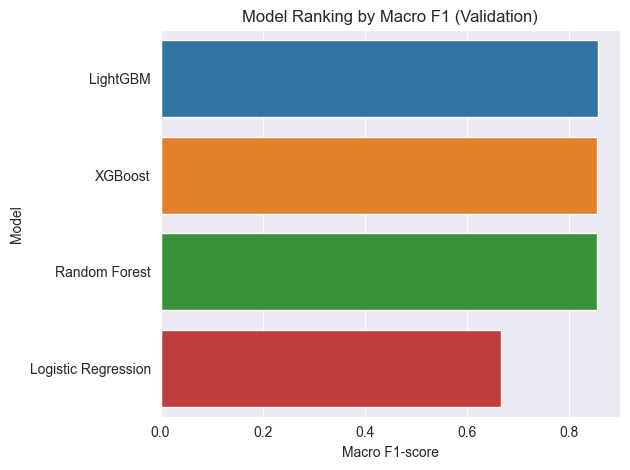


Performance on Current Data:
              precision    recall  f1-score   support

           0       0.94      0.77      0.85     12554
           1       0.90      0.98      0.94     26163

    accuracy                           0.91     38717
   macro avg       0.92      0.87      0.89     38717
weighted avg       0.91      0.91      0.91     38717

Accuracy: 0.9101, Macro F1-score: 0.8920


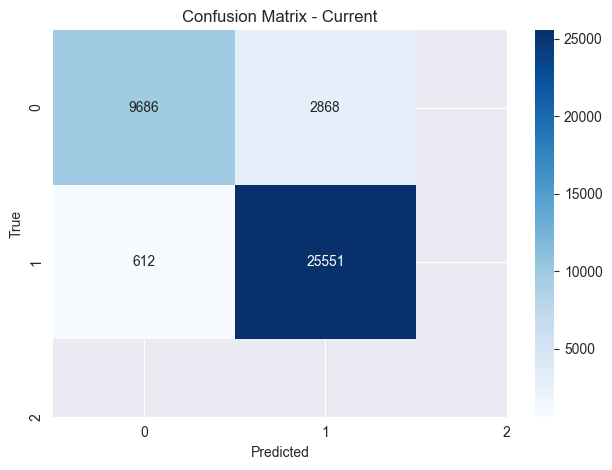


Performance on Future Data:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      6431
           1       0.94      0.94      0.94     21387

    accuracy                           0.91     27818
   macro avg       0.87      0.87      0.87     27818
weighted avg       0.91      0.91      0.91     27818

Accuracy: 0.9059, Macro F1-score: 0.8678


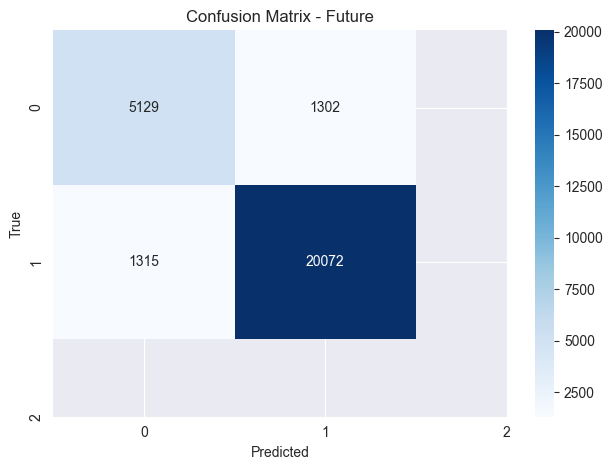

0        0
1        1
2        1
3        1
4        1
        ..
27813    1
27814    1
27815    1
27816    1
27817    1
Name: BALANCE_CLASS_PREDICTED_LightGBM, Length: 27818, dtype: int64

In [ ]:
# === Step 1: Train/Test Split
X, y = prepare_train_set(past, current)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# === Step 2: Train and Evaluate Models
best_model, best_model_name, results_df = train_models(X_train, y_train, X_val, y_val)

# === Step 3: Predict and Evaluate on Current
X_current = current.drop(columns=["SK_ID_CURR", "BALANCE_CLASS", "AVG_BALANCE"], errors="ignore")
X_current = X_current[X_train.columns]
y_current = current["BALANCE_CLASS"]
y_current_pred = evaluate_model(best_model, X_current, y_current, label="Current")

col_name = f"BALANCE_CLASS_PREDICTED_{best_model_name.replace(' ', '_')}"
current[col_name] = y_current_pred

# === Step 4: Compare with Future
comparison = current.merge(future[["SK_ID_CURR", "BALANCE_CLASS"]], on="SK_ID_CURR", suffixes=("_pred", "_true"))
evaluate_model(None, comparison[col_name], comparison["BALANCE_CLASS_true"], label="Future", precomputed=True)

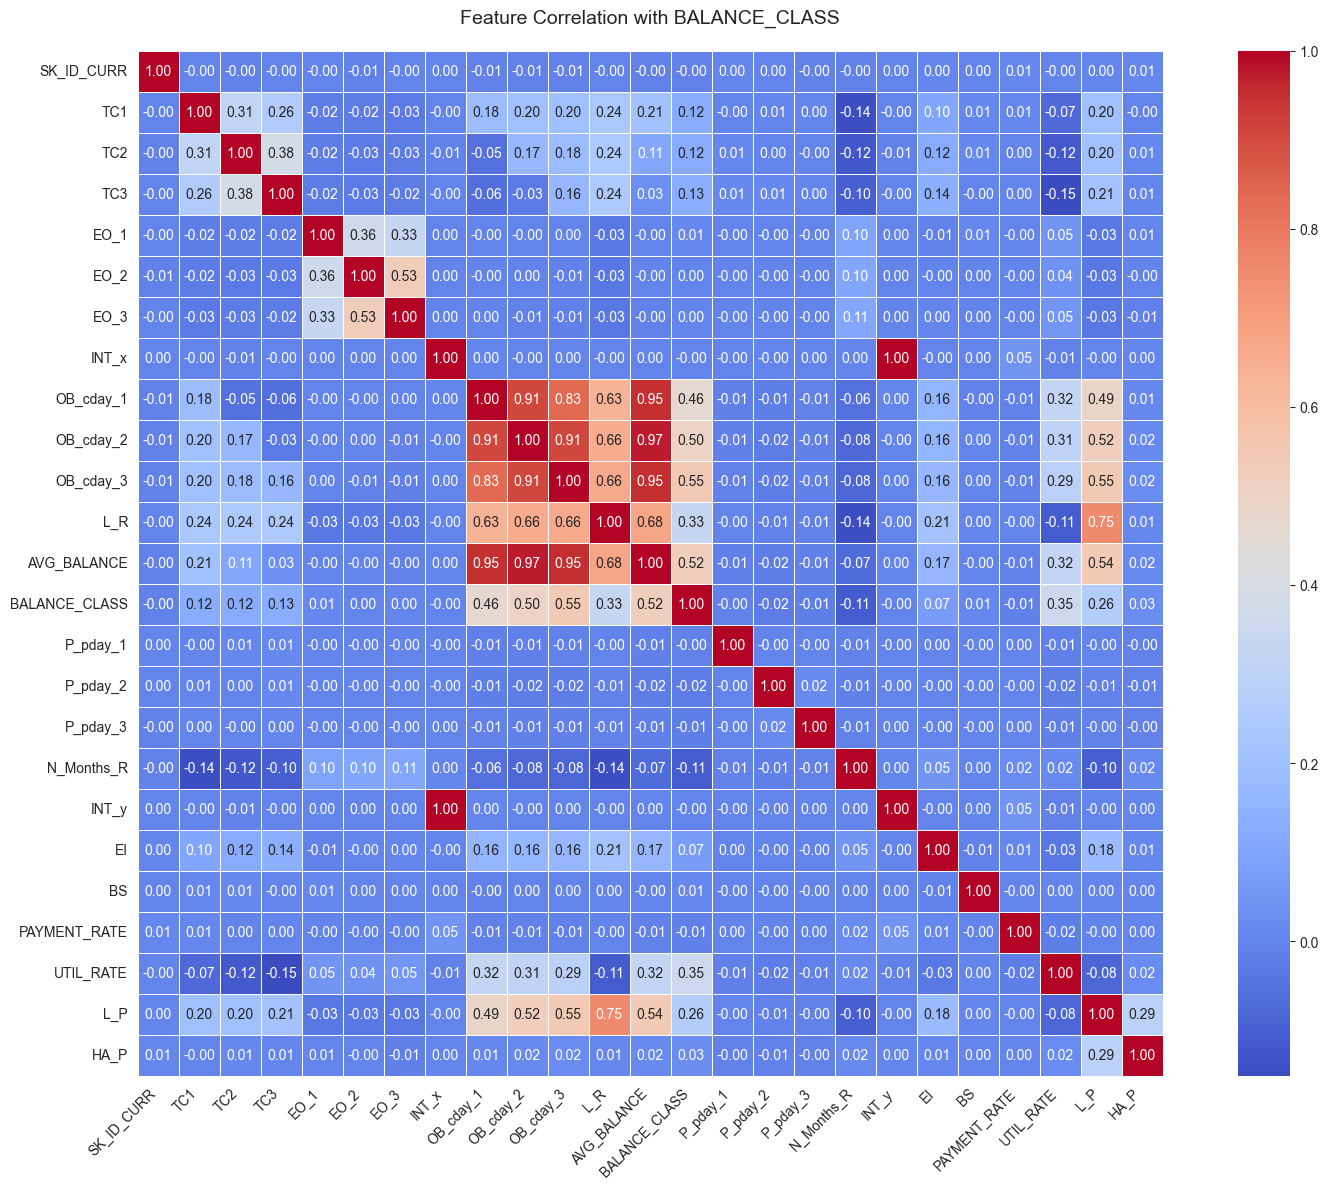


Top 10 Features - LightGBM:

      Feature  Importance
9   OB_cday_3         406
13   P_pday_3         351
2         TC3         328
7   OB_cday_1         300
12   P_pday_2         296
8   OB_cday_2         287
1         TC2         270
11   P_pday_1         262
0         TC1         249
10        L_R         228


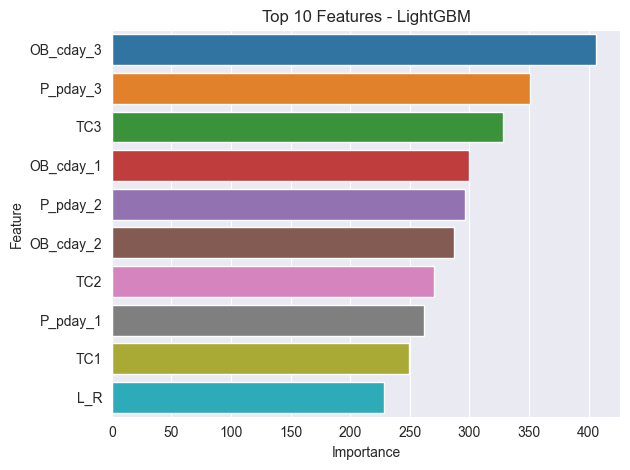

In [ ]:
# === Step 5: Final Feature Correlation
final_df = current.copy()
final_df = final_df.merge(age, on="SK_ID_CURR", how="left")
final_df = final_df.merge(interest_df, on="SK_ID_CURR", how="left")
final_df = final_df.merge(ei, on="SK_ID_CURR", how="left")
final_df = final_df.merge(bureau_score, on="SK_ID_CURR", how="left")
final_df = final_df.merge(pr_avg, on="SK_ID_CURR", how="left")
final_df = final_df.merge(ur_avg, on="SK_ID_CURR", how="left")
final_df = final_df.merge(lr_1[["SK_ID_CURR", "L_P", "HA_P"]], on="SK_ID_CURR", how="left")

final_df = final_df.fillna(final_df.median(numeric_only=True))
final_df["BALANCE_CLASS"] = final_df[col_name]
final_df.drop(columns=[col_name], inplace=True)

# === Step 6: Correlation Heatmap
plt.figure(figsize=(16, 12))
corr_matrix = final_df.corr()
sns.heatmap(
    corr_matrix,
    annot=True, fmt=".2f", cmap="coolwarm",
    annot_kws={"size": 10}, linewidths=0.5, square=True
)
plt.title("Feature Correlation with BALANCE_CLASS", fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# === Step 7: Feature Importance
plot_feature_importance(best_model, X_train, best_model_name)

In [ ]:
PROCESSED_PATH = os.path.join("..", "data", "processed")
os.makedirs(PROCESSED_PATH, exist_ok=True)  # Create folder if missing

final_df.to_csv(os.path.join(PROCESSED_PATH, "cleaned_df.csv"), index=False)

In [ ]:
final_df

,SK_ID_CURR,TC1,TC2,TC3,EO_1,EO_2,EO_3,INT_x,OB_cday_1,OB_cday_2,...,P_pday_2,P_pday_3,N_Months_R,INT_y,EI,BS,PAYMENT_RATE,UTIL_RATE,L_P,HA_P
0,100049,10736.910,0.00,0.000,0,0,0,0.1887,91464.030,88958.295,...,0.001847,0.002220,13,0.1887,135000.0,0.0,0.021173,0.668012,225000.0,0.0
1,100067,0.000,3149.01,2249.280,0,0,0,0.1887,43204.545,45465.750,...,0.049488,0.101083,87,0.1887,162000.0,0.0,0.066436,0.418133,45000.0,0.0
2,100075,145125.000,27000.00,8100.000,0,0,0,0.1887,245289.465,187643.295,...,0.497768,0.281892,8,0.1887,112500.0,0.0,0.337542,0.761581,225000.0,0.0
3,100101,29578.950,0.00,179293.635,0,0,0,0.1887,213464.115,150263.010,...,0.456055,0.315857,14,0.1887,202500.0,0.0,1.009782,0.308743,630000.0,0.0
4,100107,79360.155,47344.23,18826.155,0,0,0,0.1887,86821.470,100519.560,...,0.182105,0.008163,11,0.1887,180000.0,0.0,0.106371,0.870598,135000.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39182,456233,0.000,15192.45,14503.590,0,0,0,0.1887,23533.470,37644.120,...,0.059770,0.103313,10,0.1887,225000.0,0.0,0.052997,0.190506,180000.0,0.0
39183,456237,0.000,1350.00,0.000,0,0,0,0.1887,89195.850,2136.600,...,42.122999,0.053378,15,0.1887,135000.0,0.0,36.716384,0.269698,0.0,0.0
39184,456242,98550.000,51734.25,45192.240,0,0,0,0.1887,126676.665,173296.170,...,0.064918,0.248415,8,0.1887,198000.0,0.0,0.104444,0.634467,337500.0,1.0
39185,456246,45507.600,0.00,0.000,0,0,0,0.1887,43490.115,1444.140,...,28.681229,0.053378,8,0.1887,94500.0,0.0,0.552953,0.066584,225000.0,0.0
